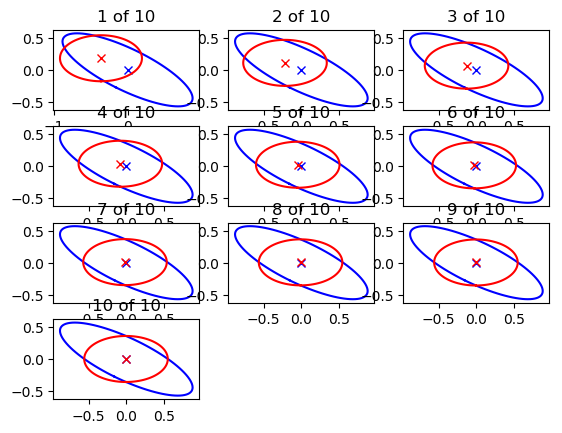

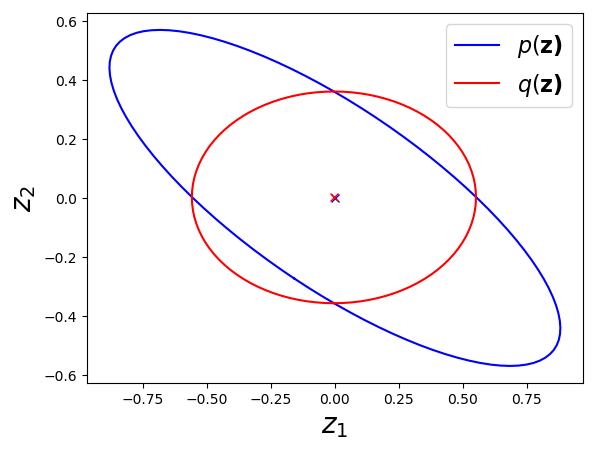

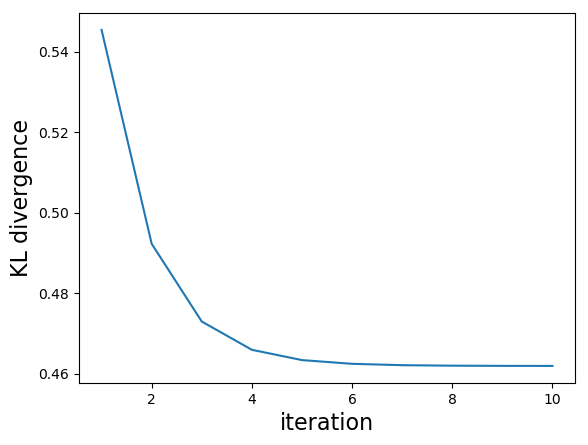

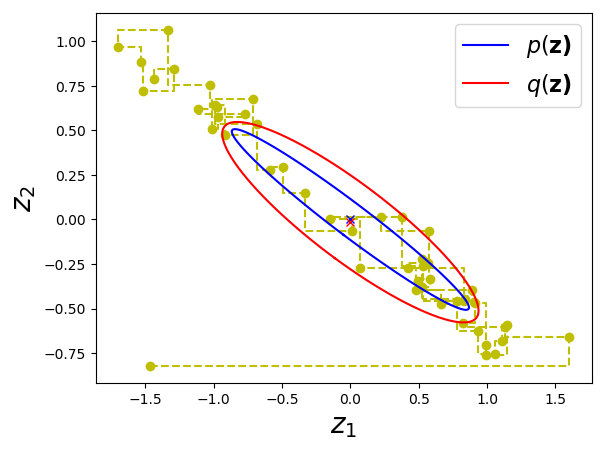

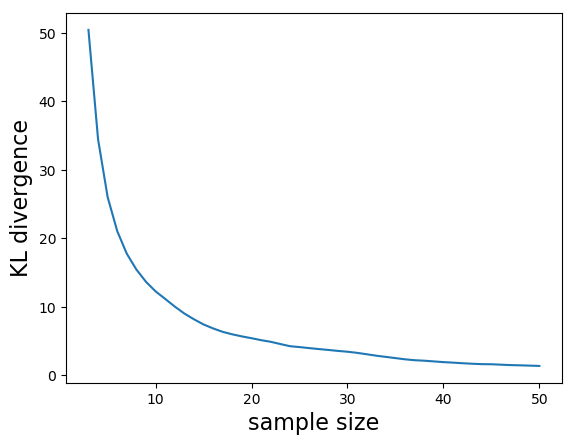

In [1]:
###################################
## Simple VI & GS for 2D Gaussian

using PyPlot
using Distributions

function calc_KL(mu1, lambda1, mu2, lambda2)
    D = size(mu1, 1)
    px_lnqx = 0.5 * logdet(lambda2) - 0.5 * ((mu1 - mu2)' * lambda2 * (mu1 - mu2) + trace(lambda2 * inv(lambda1)))
    px_lnpx = 0.5 * logdet(lambda1) - 0.5 * D
    KL = - (px_lnqx - px_lnpx)
    return KL[1]
end

function plot_results(result, truth)
    N = size(result, 1)
    H = Int(ceil(sqrt(N)))
    W = Int(ceil(N / H))
    for i in 1 : H
        for j in 1 : W
            n = (i - 1) * W + j
            if n <= N
                subplot(H, W, n)
                title("$n of $N")
                plot_gaussian(truth[1], truth[2], "b", "\$p(z)\$")
                plot_gaussian(result[n][1], result[n][2], "r", "\$p(z)\$")
            end
        end
    end
end

function plot_lines(X)
    D, N = size(X)
    X_d = zeros(D, 2*N + 1)
    X_d[:,1] = X[:,1]
    for i in 1 : N
        X_d[1, 2*i - 1] = X[1, i]
        X_d[1, 2*i] = X[1, i]
        X_d[2, 2*i] = X[2, i]
        X_d[2, 2*i + 1] = X[2, i]
    end
    plot(X[1,:], X[2,:], "oy")
    plot(X_d[1,1:2*N], X_d[2,1:2*N], "--y")
end

function plot_gaussian(Mu, Sigma, col, label)
    res = 100
    plot(Mu[1], Mu[2], "x", color=col)
    
    F = eigfact(Sigma)
    vec = F.vectors
    val = F.values
    dw = 2*pi/res
    w = dw * (0 : res)
    
    c = 1.0
    a = sqrt(c*val[1])
    b = sqrt(c*val[2])
    P1 = a*cos.(w)
    P2 = b*sin.(w)
    P = Mu .+ vec'*vcat(P1', P2')
    plot(P[1, :], P[2, :], "-", color=col, label=label)
end

"""
Variational inference for 2D Gauss.
"""
function main_VI()
    ## creat truth distribution
    D = 2 # dimension
    theta = 2.0*pi/12 # tilt
    A = reshape([cos.(theta), -sin.(theta),
                 sin.(theta), cos.(theta)],
                2, 2)
    mu = [0.0, 0.0]
    lambda = inv(A * inv(reshape([1,0,0,10], 2, 2)) * A')
    
    ## initialize
    #mu_h = randn(D)
    mu_h = [-0.5, 0.3]
    lambda_h = zeros(D,D)
    
    ## main iteration
    max_iter = 10
    KL = NaN * Array{Float64, 1}(max_iter)
    result = Array{Any, 1}(max_iter)
    for i in 1 : max_iter
        ## update
        mu_h[1] = mu[1] - inv(lambda[1,1])*lambda[1,2] * (mu_h[2] - mu[2])
        
        lambda_h[1,1] = lambda[1,1]
        mu_h[2] = mu[2] - inv(lambda[2,2])*lambda[2,1] * (mu_h[1] - mu[1])
        lambda_h[2,2] = lambda[2,2]
        
        ## calculate KL divergeince
        KL[i] = calc_KL(mu_h, lambda_h, mu, lambda)

        ## store the results
        result[i] = [deepcopy(mu_h), deepcopy(inv(lambda_h))]
    end

    ## visualize results
    figure("result per iteration (VI)")
    clf()
    plot_results(result, (mu, inv(lambda)))

    figure("result (VI)")
    clf()
    plot_gaussian(mu, inv(lambda), "b", "\$p(\\bf{z})\$")
    plot_gaussian(result[end][1], result[end][2], "r", "\$q(\\bf{z})\$")
    xlabel("\$z_1\$", fontsize=20)
    ylabel("\$z_2\$", fontsize=20)
    legend(fontsize=16)
    
    figure("KL divergence (VI)")
    clf()
    plot(1:max_iter, KL)
    ylabel("KL divergence", fontsize=16)
    xlabel("iteration", fontsize=16)
    show()
end

"""
Gibbs sampling for 2D Gauss.
"""
function main_GS()
    ## creat truth distribution
    D = 2 # dimension
    theta = 2.0*pi/12 # tilt
    A = reshape([cos.(theta), -sin.(theta),
                 sin.(theta), cos.(theta)],
                2, 2)
    mu = [0.0, 0.0]
    #lambda = inv(A * inv(reshape([1,0,0,10], 2, 2)) * A')
    lambda = inv(A * inv(reshape([1,0,0,100], 2, 2)) * A')

    ## initialize
    #max_iter = 1000
    max_iter = 50
    X = randn(D, max_iter)
    mu_h = randn(D)
    
    ## main iteration
    KL = NaN * Array{Float64, 1}(max_iter)
    for i in 2 : max_iter
        ## update
        mu_h[1] = mu[1] - inv(lambda[1,1])*lambda[1,2] * (X[2,i-1] - mu[2])
        X[1, i] = rand(Normal(mu_h[1], sqrt(inv(lambda[1,1]))))
        
        mu_h[2] = mu[2] - inv(lambda[2,2])*lambda[2,1] * (X[1,i] - mu[1])
        X[2, i] = rand(Normal(mu_h[2], sqrt(inv(lambda[2,2]))))        
        
        if i > D
            KL[i] = calc_KL(mean(X[:,1:i], 2), inv(cov(X[:,1:i], 2)), mu, lambda)
        end
    end
    
    ## visualize results
    expt_mu = mean(X, 2)
    expt_Sigma = cov(X, 2)

    figure("samples (GS)")
    clf()
    plot_lines(X)
    plot_gaussian(mu, inv(lambda), "b", "\$p(\\bf{z})\$")
    plot_gaussian(expt_mu, expt_Sigma, "r", "\$q(\\bf{z})\$")
    xlabel("\$z_1\$", fontsize=20)
    ylabel("\$z_2\$", fontsize=20)
    legend(fontsize=16)
    
    figure("KL divergence (GS)")
    clf()
    plot(1:max_iter, KL)
    ylabel("KL divergence", fontsize=16)
    xlabel("sample size", fontsize=16)
    show()
end

main_VI()
main_GS()